# Fine-Tuning on Recorded Data

In [71]:
# Imports
import numpy as np
import pickle


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, AvgPool1D, MaxPool1D, ZeroPadding1D, BatchNormalization, Flatten, Dense, Activation, GlobalAveragePooling1D
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import kerascnn2c
from pathlib import Path
import copy

In [72]:
def fixed_point_conversion(x: np.array, fixed_point: int):
  x /= 2**fixed_point
  return x

## Read Data

In [73]:
data_dir = '../../data/fine-tuning/fine-tune.pkl'

with open(data_dir, 'rb') as file:
    data = pickle.load(file)
file.close()

x = data['x']
y = data['y']

permutation = np.random.permutation(len(x))
x = x[permutation]
y = y[permutation]

min_int16 = fixed_point_conversion(-(2**15), 9)
max_int16 = fixed_point_conversion((2**15)-1, 9)

scaler = MinMaxScaler(feature_range=(min_int16, max_int16))

x = np.array([scaler.fit_transform(np.array(i).reshape((16000,1))) for i in x])

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')


X shape: (940, 16000, 1)
Y shape: (940, 5)


In [74]:
# splitting into training and validation data
test_split = int(0.8*len(x))

x_inter, x_test = x[:test_split,:], x[test_split:,:]
y_inter, y_test = y[:test_split,:], y[test_split:,:]

train_split = int(0.9*len(x_inter))
print(train_split)

x_train, x_val = x_inter[:train_split,:], x_inter[train_split:,:]
y_train, y_val = y_inter[:train_split,:], y_inter[train_split:,:]

print(f'X train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print('---------------------------')
print(f'X val: {x_val.shape}')
print(f'y val: {y_val.shape}')
print('---------------------------')
print(f'X test: {x_test.shape}')
print(f'y test: {y_test.shape}')

676
X train: (676, 16000, 1)
y train: (676, 5)
---------------------------
X val: (76, 16000, 1)
y val: (76, 5)
---------------------------
X test: (188, 16000, 1)
y test: (188, 5)


--------------------------------COUNT EN---------------------------------
Train	 EN: 114
Val	 EN: 15
--------------------------------COUNT DE---------------------------------
Train	 DE: 165
Val	 DE: 25
--------------------------------COUNT ES---------------------------------
Train	 ES: 118
Val	 ES: 8
--------------------------------COUNT FR---------------------------------
Train	 FR: 148
Val	 FR: 12
--------------------------------COUNT IT---------------------------------
Train	 IT: 131
Val	 IT: 16
-------------------------------------------------------------------------
--------------------------------MINIMUM COUNTS---------------------------------
Min count train: 114
Min count val: 8
-------------------------------------------------------------------------


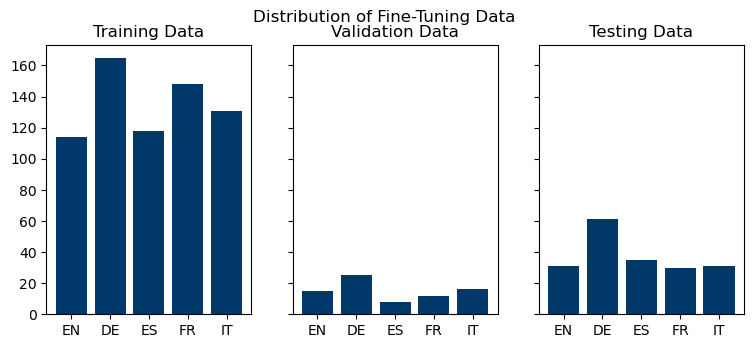

In [75]:
import matplotlib.pyplot as plt

labels_train = [np.argmax(i) for i in y_train]
labels_val = [np.argmax(i) for i in y_val]
labels_test = [np.argmax(i) for i in y_test]

unique_train, counts_train = np.unique(labels_train, return_counts=True)
unique_val, counts_val = np.unique(labels_val, return_counts=True)
unique_test, counts_test = np.unique(labels_test, return_counts=True)


del labels_train
# del labels_test
del labels_val

# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr', 'fleurs.it_it']
# LABELS = ['EN', 'DE', 'ES', 'FR', 'IT']
LABELS = ['EN', 'DE', 'ES', 'FR', 'IT']




fig, axes = plt.subplots(1,3, figsize=(9, 3.5), sharey=True, edgecolor='black')
axes[0].bar(LABELS, counts_train, color='#01386a')
axes[0].set_title('Training Data')

axes[1].bar(LABELS, counts_val, color='#01386a')
axes[1].set_title('Validation Data')

axes[2].bar(LABELS, counts_test, color='#01386a')
axes[2].set_title('Testing Data')

fig.suptitle('Distribution of Fine-Tuning Data')


for enum, i in enumerate(counts_train):
    print(f'--------------------------------COUNT {LABELS[enum]}---------------------------------')
    print(f'Train\t {LABELS[enum]}: {i}')
    # print(f'Test\t {LABELS[enum]}: {counts_test[enum]}')
    print(f'Val\t {LABELS[enum]}: {counts_val[enum]}')
print('-------------------------------------------------------------------------')

print('--------------------------------MINIMUM COUNTS---------------------------------')
print(f'Min count train: {min(counts_train)}')
# print(f'Min count test: {min(counts_test)}')
print(f'Min count val: {min(counts_val)}')
print('-------------------------------------------------------------------------')

In [76]:
# Available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Name of Devices: ', tf.config.list_physical_devices())

Num GPUs Available:  1
Name of Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [77]:
model = Sequential()
model.add(Input(shape=(16000, 1)))
model.add(Conv1D(filters=8, kernel_size=20, strides=10,activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=8, strides=4, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, strides=2, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(AvgPool1D(4))
model.add(Flatten())
# model.add(Dense(units=128))
model.add(Dense(units=5))
model.add(Activation('softmax'))

# EXPLORE Learning Rate
earlystopping = EarlyStopping(monitor = "val_loss", patience  = 5)
opt = tf.keras.optimizers.Adam(lr=10e-4, decay = 10e-6)

model_path = '../models/no-pre-training'
model_name = 'language-detection-no-pretraining'

# EARLY STOPPING
callback_path = f'{model_path}/checkpoints/{model_name}.ckpt' # save weights to this directory
checkpoint = tf.keras.callbacks.ModelCheckpoint(callback_path,
                                                save_weights_only=True,
                                                verbose=1,
                                                save_best_only=True)

model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1599, 8)           168       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 799, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 32)            2080      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 24, 32)           0

/opt/homebrew/Caskroom/miniforge/base/envs/embeddedAI/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [78]:
# # Create a basic model instance
# model_path = '../models/language-detection-full-data/fine-tuning'
# model_name = 'language-detection-0.6'

# checkpoint_path = '../models/language-detection-full-data/pre-trained'


# model = keras.models.load_model(checkpoint_path)

# opt = tf.keras.optimizers.Adam(lr=10e-6)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# # for layer in model.layers[:4]:
# #     layer.trainable = False

# model.summary()

In [80]:
# Training model with GPU
with tf.device('/gpu:0'):
  history = model.fit(x_train, y_train, epochs=10, batch_size=4, validation_data=(x_val, y_val))

Epoch 1/10
169/169 [==============================] - 2s 12ms/step - loss: 2.8052e-06 - categorical_accuracy: 1.0000 - val_loss: 5.2748 - val_categorical_accuracy: 0.3684
Epoch 2/10
169/169 [==============================] - 2s 12ms/step - loss: 2.5063e-06 - categorical_accuracy: 1.0000 - val_loss: 5.2776 - val_categorical_accuracy: 0.3684
Epoch 3/10
169/169 [==============================] - 2s 12ms/step - loss: 2.2982e-06 - categorical_accuracy: 1.0000 - val_loss: 5.3287 - val_categorical_accuracy: 0.3684
Epoch 4/10
169/169 [==============================] - 2s 12ms/step - loss: 2.0870e-06 - categorical_accuracy: 1.0000 - val_loss: 5.3739 - val_categorical_accuracy: 0.3684
Epoch 5/10
169/169 [==============================] - 2s 12ms/step - loss: 1.9018e-06 - categorical_accuracy: 1.0000 - val_loss: 5.4371 - val_categorical_accuracy: 0.3684
Epoch 6/10
169/169 [==============================] - 2s 12ms/step - loss: 1.7245e-06 - categorical_accuracy: 1.0000 - val_loss: 5.4810 - val_cat

In [ ]:
model.save(model_path)

INFO:tensorflow:Assets written to: ../models/language-detection-full-data/fine-tuning/assets


INFO:tensorflow:Assets written to: ../models/language-detection-full-data/fine-tuning/assets


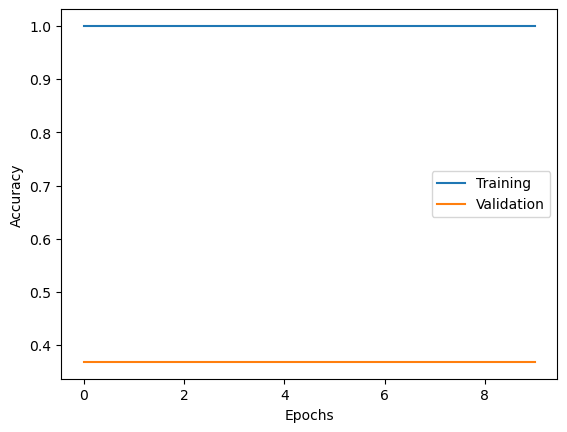

In [81]:
plt.plot(range(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
plt.plot(range(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', 'Validation'])
plt.show()

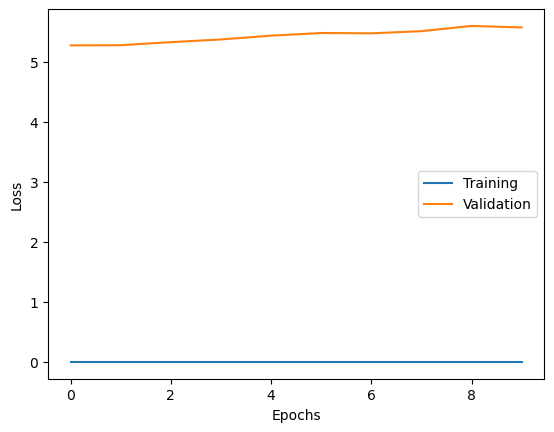

In [82]:
plt.plot(range(0, len(history.history['loss'])), history.history['loss'])
plt.plot(range(0, len(history.history['val_loss'])), history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'])
plt.show()

6/6 [==============================] - 0s 10ms/step
Overall Accuracy: 0.39361702127659576


2023-05-01 19:11:17.430518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


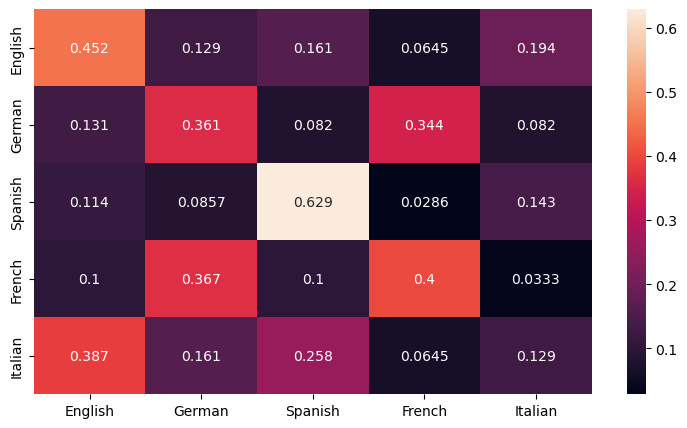

In [83]:
# Confusion matrix:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

preds = model.predict(x_test)
y_classes = preds.argmax(axis=-1)
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy = accuracy_score(y_true = y_test.argmax(axis=-1), y_pred = y_classes)
print(f'Overall Accuracy: {accuracy}')
cm = confusion_matrix(y_true = y_test.argmax(axis=-1), y_pred = y_classes, normalize='true')

NAMES = ['English', 'German', 'Spanish', 'French', 'Italian']

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (9,5))
sn.heatmap(df_cm, annot=True, fmt = '.3g', xticklabels=NAMES, yticklabels=NAMES)
plt.show()



In [84]:
model.save(f'{model_path}/{model_name}/keras2c/gsc_no_globalavg.h5')

# remove softmax
model = tf.keras.Model(model.input, model.layers[-2].output, name=model.name)

In [85]:
FIXED_POINT=9
res = kerascnn2c.Converter(output_path=Path(f'{model_path}/{model_name}/keras2c/gsc_output_fixed'),
                           fixed_point=FIXED_POINT, # Number of bits for the fractional part, Q7.9 format
                           number_type='int16_t', # Data type for weights/activations (16 bits quantization)
                           long_number_type='int32_t', # Data type for intermediate results
                           number_min=-(2**15), # Minimum value for 16-bit signed integers
                           number_max=(2**15)-1 # Maximum value for 16-bit signed integers
                          ).convert_model(copy.deepcopy(model))
with open(f'{model_path}/{model_name}/keras2c/gsc_model_fixed.h', 'w') as f:
    f.write(res)

INFO:tensorflow:Assets written to: ram://e36d49bb-a4ef-4001-9bc7-27921f39bbbc/assets


INFO:tensorflow:Assets written to: ram://e36d49bb-a4ef-4001-9bc7-27921f39bbbc/assets


———————————————————————————————————————————————————————————————————————————————————————————————————————
Inputs                           | Layer                            | Outputs                         
———————————————————————————————————————————————————————————————————————————————————————————————————————
                                 | input_1                          | conv1d                          
-------------------------------------------------------------------------------------------------------
input_1                          | conv1d                           | max_pooling1d                   
-------------------------------------------------------------------------------------------------------
conv1d                           | max_pooling1d                    | conv1d_1                        
-------------------------------------------------------------------------------------------------------
max_pooling1d                    | conv1d_1                         

In [86]:
# Turn testing data into CSV file for with compiled version
np.savetxt("x_test.csv", x_test.reshape((x_test.shape[0], x_test.shape[1])), delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")

In [88]:
!g++ -std=c++17 -Wall -Wextra -pedantic -Ofast -o gsc_fixed -I gsc_output_fixed/ gsc_output_fixed/model.c main.cpp 
!./gsc_fixed x_test.csv y_test.csv

clang: warning: treating 'c' input as 'c++' when in C++ mode, this behavior is deprecated [-Wdeprecated]
gsc_output_fixed/model.c:137:18: warning: expression result unused [-Wunused-value]
    activations2.average_pooling1d_output,
    ~~~~~~~~~~~~ ^~~~~~~~~~~~~~~~~~~~~~~~
gsc_output_fixed/model.c:138:18: warning: expression result unused [-Wunused-value]
    activations2.flatten_output
    ~~~~~~~~~~~~ ^~~~~~~~~~~~~~
2 warnings generated.
Testing accuracy: 0.37766
